<a href="https://colab.research.google.com/github/SFIComplexityExplorer/Mesa-ABM-Tutorial/blob/main/Session_19_Data_Collector_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


try: 
  import mesa
except: 
  !pip install mesa --quiet
import mesa
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.6 MB/s eta 0:00:00


# Helper Functions

In [ ]:
def get_distance(pos_1, pos_2):
  '''
  Calculate the Euclidean distance between two positions

  used in trade.move()
  '''

  x1, y1 = pos_1
  x2, y2 = pos_2
  dx = x1 - x2
  dy = y1 - y2
  return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
  '''
  helper function for model datacollector for trade price
  collapses agent price list into one list
  '''
  return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
  '''
  find the geometric mean of a list of prices
  '''
  return np.exp(np.log(list_of_prices).mean())

def get_trade(agent):
  '''
  For agent reportes in data collector

  return list of trade partners and None for other agents
  '''
  if type(agent) == Trader: 
    return agent.trade_partners
  else: return None  

# Resource Classes

In [ ]:
class Sugar(mesa.Agent):
  """
  Sugar: 
  - contains an amount of sugar
  - grows 1 amount of sugar at each turn 
  """

  def __init__(self, unique_id, model, pos, max_sugar): 
    super().__init__(unique_id, model)
    self.pos = pos
    self.amount = max_sugar
    self.max_sugar = max_sugar


  def step(self):
    '''
    Sugar growth function, adds one unit of sugar each step until
    max amount
    '''
    self.amount = min([self.max_sugar, self.amount+1])

In [ ]:
class Spice(mesa.Agent):
  """
  Spice: 
  - contains an amount of spice
  - grows 1 amount of spice at each turn
  """

  def __init__(self, unique_id, model, pos, max_spice):
    super().__init__(unique_id, model)
    self.pos = pos
    self.amount = max_spice
    self.max_spice = max_spice
  
  def step(self): 
    '''
    Spice growth function, adds one unit of spice each step until
    max amout
    '''
    self.amount = min([self.max_spice, self.amount+1])

# Trader Agent

In [ ]:
class Trader(mesa.Agent): 
  """
  Trader: 
  - has a metabolism of sugar and spice
  - harvest and trade sugar and spice to survive
  """


  def __init__(self, unique_id, model, pos, moore=False, sugar=0, 
               spice=0, metabolism_sugar=0, metabolism_spice=0, 
               vision=0):
    super().__init__(unique_id, model)
    self.pos = pos
    self.moore = moore
    self.sugar = sugar
    self.spice = spice
    self.metabolism_sugar = metabolism_sugar
    self.metabolism_spice = metabolism_spice
    self.vision = vision
    self.prices = []
    self.trade_partners = []

  
  def get_sugar(self, pos):
    '''
    used in self.get_sugar_amount()
    '''

    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if type(agent) is Sugar:
        return agent
    return None
  
  
  def get_sugar_amount(self,pos):
    '''
    used in self.move() as part of self.calculate_welfare()
    '''

    sugar_patch = self.get_sugar(pos)
    if sugar_patch:
      return sugar_patch.amount
    return 0
  
  def get_spice(self, pos):
    '''
    used in self.get_spice_amount()
    '''

    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell: 
      if type(agent) is Spice: 
        return agent
    return None

  def get_spice_amount(self, pos):
    '''
    used in self.move() as part of self.calculate_welfare()
    '''

    spice_patch = self.get_spice(pos)
    if spice_patch: 
      return spice_patch.amount
    return 0
  
  def get_trader(self, pos):
      '''
      helper function used in self.trade_with_neighbors()
      '''

      this_cell = self.model.grid.get_cell_list_contents(pos)

      for agent in this_cell: 
        if isinstance(agent, Trader):
          return agent
  
  
  def is_occupied_by_other(self,pos):
    '''
    helper function part 1 of self.move()
    '''

    if pos == self.pos: 
      # agent's position is considered unoccupied as agent can stay there
      return False
    # get contents of each cell in neighborhood
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for a in this_cell: 
      # see if occupied by another agent
      if isinstance(a, Trader): 
        return True
    return False
  
  def calculate_welfare(self, sugar, spice):
    '''
    helper function 
    
    part 2 self.move()
    self.trade()
    '''

    # calculate total resources
    m_total = self.metabolism_sugar + self.metabolism_spice
    # Cobb-Douglas functional form; starting on p. 97 on Growing Artificial Societies 
    return sugar**(self.metabolism_sugar/m_total) * spice**(
        self.metabolism_spice/m_total)
  
  
  def is_starved(self):
    '''
    Helper function for self.maybe_die()
    '''

    return (self.sugar <= 0) or (self.spice <= 0)

  def calculate_MRS(self):
    '''
    Helper function for self.trade()

    Determines what trader agent is needs and can give up
    '''

    return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)
  
  def calculate_sell_spice_amount(self, price):
    '''
    helper function for self.maybe_sell_spice() which is called from 
    self.trade()
    '''

    if price >= 1: 
      sugar = 1
      spice = int(price)
    else: 
      sugar = int(1/price)
      spice = 1
    return sugar, spice
  
  def sell_spice(self, other, sugar, spice):
    '''
    used in self.maybe_sell_spice()

    exchanges sugar and spice between traders
    '''

    self.sugar += sugar
    other.sugar -= sugar
    self.spice -= spice
    other.spice += spice
  
  
  def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
    '''
    helper function for self.trade()
    '''

    sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

    # Assess new sugar and spice amount - what if change did occur
    self_sugar = self.sugar + sugar_exchanged
    other_sugar = other.sugar - sugar_exchanged
    self_spice = self.spice - spice_exchanged
    other_spice = other.spice + spice_exchanged

    # double check to ensure agents have resources

    if ((self_sugar <= 0) or
        (other_sugar <=0) or 
        (self_spice <= 0) or
        (other_spice <= 0)):
      return False

    # trade criteria #1 - are both agents better off? 
    both_agents_better_off = (
        (welfare_self < self.calculate_welfare(self_sugar, self_spice)) and
        (welfare_other < other.calculate_welfare(other_sugar, other_spice)))
    
    # trade criteria #2 is their mrs crossing
    mrs_not_crossing = self.calculate_MRS() > other.calculate_MRS()

    if not (both_agents_better_off and mrs_not_crossing):
      return False

    # criteria met, execute trade
    self.sell_spice(other, sugar_exchanged, spice_exchanged)

    return True
  
  
  def trade(self, other):
    '''
    helper function used in trade_with_neighbors()

    other is a trader agent object
    '''

    # sanity check to verify code is working as expected 
    assert self.sugar > 0
    assert self.spice > 0
    assert other.sugar > 0
    assert other.spice > 0
  
    # calculate marginal rate of subsitution in Growing Artificial Socieites p. 101
    mrs_self = self.calculate_MRS()
    mrs_other = other.calculate_MRS()

    #calculate each agents welfare
    welfare_self = self.calculate_welfare(self.sugar, self.spice)
    welfare_other = other.calculate_welfare(other.sugar, other.spice)

    if math.isclose(mrs_self, mrs_other): 
      return

    # calcualte price
    price = math.sqrt(mrs_self*mrs_other)
    
    if mrs_self > mrs_other: 
      # self is a sugar buyer, spice seller
      sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
      # no trade - criteria not met
      if not sold: 
        return
    else: 
      # self is a spice buyer, sugar seller
      sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
      # no trade - criteria not met
      if not sold: 
        return
    
    # Capture data
    self.prices.append(price)
    self.trade_partners.append(other.unique_id)

    # continue trading
    self.trade(other)

  ######################################################################
  #                                                                    #  
  #                      MAIN TRADE FUNCTIONS                          #  
  #                                                                    #
  ######################################################################
  
  
  def move(self):
    '''
    Function for trader agent to identify optimal move for each step in 4 parts
    1 - identify all possible moves
    2 - determine which move maximizes welfare
    3 - find closest best option
    4 - move
    '''

    # 1. identify all possible moves

    neighbors = [i
                 for i in self.model.grid.get_neighborhood(
                   self.pos, self.moore, True, self.vision  
                 ) if not self.is_occupied_by_other(i)]

    # 2. determine which move maximizes welfare

    welfares = [
        self.calculate_welfare(
            self.sugar + self.get_sugar_amount(pos),
            self.spice + self.get_spice_amount(pos)) 
        for pos in neighbors
    ]

    # 3. Find closest best option

    # find the highest welfare in welfares 
    max_welfare = max(welfares)
    # get the index of max welfare cells
    candidate_indices = [i for i in range(len(welfares))
                        if math.isclose(welfares[i], max_welfare)]

    # convert index to positions of those cells
    candidates = [neighbors[i] for i in candidate_indices]

    min_dist = min(get_distance(self.pos, pos) for pos in candidates)

    final_candidates = [ pos for pos in candidates
                       if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol=1e-02
                                       )]
    self.random.shuffle(final_candidates)

    # 4. Move Agent
    self.model.grid.move_agent(self, final_candidates[0])

  def eat(self): 
    '''
    Function for trader to consume sugar and spice in grid cell
    '''
    
    # get sugar
    sugar_patch = self.get_sugar(self.pos)
    # eat sugar
    if sugar_patch: 
      self.sugar = self.sugar - self.metabolism_sugar + sugar_patch.amount
      sugar_patch.amount = 0

    # get spice
    spice_patch = self.get_spice(self.pos)
    # eat spice
    if spice_patch:
      self.spice = self.spice - self.metabolism_spice + spice_patch.amount
      spice_patch.amount = 0

  def maybe_die(self):
    '''
    Function to remove Traders who have consumed all their sugar or spice
    '''

    if self.is_starved(): 
      self.model.grid.remove_agent(self)
      self.model.schedule.remove(self)

  def trade_with_neighbors(self):
    '''
    Function for trader agents to decide who to trade with in three parts

    1- identify neighbors who can trade
    2- trade (2 sessions)
    3- collect data
    '''

    neighbor_agents = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
        self.pos, self.moore, False, self.vision) if self.is_occupied_by_other(pos)
    ]

    if len(neighbor_agents) == 0: 
      return 
    

    # iterate through traders in neighboring cells and trade
    for a in neighbor_agents: 
      if a: 
        self.trade(a)
    
    return

# Model Class

In [ ]:
class SugarscapeG1mt(mesa.Model):
  """
  Manager class to run Sugarscape with Traders
  """
  
  
  def __init__(self, width=50,height=50, initial_population=200,
               endowment_min=25, endowment_max=50, metabolism_min=1,
               metabolism_max=5, vision_min=1, vision_max=5):
    
    #Initiate width and heigh of sugarscape
    self.width = width
    self.height = height 
    #Initiate population attributes
    self.initial_population = initial_population
    self.endowment_min = endowment_min
    self.endowment_max = endowment_max
    self.metabolism_min = metabolism_min
    self.metabolism_max = metabolism_max
    self.vision_min = vision_min
    self.vision_max = vision_max

    # initiate activation schedule
    self.schedule = mesa.time.RandomActivationByType(self)    
    # initiate mesa grid class
    self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)
    # initiate datacollector
    self.datacollector = mesa.DataCollector(
        model_reporters = {"Trader": lambda m: m.schedule.get_type_count(Trader),
         "Trade Volume": lambda m: sum(len(a.trade_partners)
         for a in m.schedule.agents_by_type[Trader].values()),
         "Price": lambda m: geometric_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values()]))}, 
       agent_reporters = {"Trade Network": lambda a: get_trade(a)}  
    )


    #read in landscape file from supplmentary material 
    sugar_distribution =np.genfromtxt("/content/drive/MyDrive/sugar-map.txt")
    spice_distribution = np.flip(sugar_distribution, 1)
    
    agent_id = 0
    for _,x,y in self.grid.coord_iter():
      max_sugar = sugar_distribution[x,y]
      if max_sugar > 0: 
        sugar = Sugar(agent_id, self, (x,y), max_sugar)
        self.schedule.add(sugar)
        self.grid.place_agent(sugar, (x,y))
        agent_id += 1
    
      max_spice = spice_distribution[x,y]
      if max_spice > 0: 
        spice = Spice(agent_id, self, (x,y), max_spice)
        self.schedule.add(spice)
        self.grid.place_agent(spice, (x,y))
        agent_id += 1    

    for i in range(self.initial_population):
      #get agent position
      x = self.random.randrange(self.width)
      y = self.random.randrange(self.height)
      #see Growing Artificial Societies p. 108 for initialization
      #give agents initial endowment
      sugar = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
      spice = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
      #give agents initial metabolism
      metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
      metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
      #give agents vision
      vision = int(self.random.uniform(self.vision_min, self.vision_max+1))
      #create Trader object
      trader = Trader(agent_id, 
                      self,
                      (x,y),
                      moore = False, 
                      sugar = sugar, 
                      spice = spice, 
                      metabolism_sugar = metabolism_sugar, 
                      metabolism_spice = metabolism_spice, 
                      vision = vision)
      #place agent
      self.grid.place_agent(trader, (x,y))
      self.schedule.add(trader)
      agent_id += 1

  def randomize_traders(self): 
    '''
    helper function for self.step()

    puts traders in randomized list for step function
    '''

    trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
    self.random.shuffle(trader_shuffle)

    return trader_shuffle
  
  
  def step(self):
    '''
    Unique step function that does staged activation of sugar and spice
    and then randomly activates traders
    '''    
    # step Sugar agents
    for sugar in self.schedule.agents_by_type[Sugar].values(): 
      sugar.step()
    
    # step Spice agents
    for spice in self.schedule.agents_by_type[Spice].values(): 
      spice.step()

    # step trader agents
    # to account for agent death and removal we need a seperate data strcuture to 
    # iterate
    trader_shuffle = self.randomize_traders()
    
    for agent in trader_shuffle: 
      agent.prices = []
      agent.trade_partners = []
      agent.move()
      agent.eat()
      agent.maybe_die()

    trader_shuffle = self.randomize_traders()

    for agent in trader_shuffle:
      agent.trade_with_neighbors()
    
    self.schedule.steps += 1 #important for data collector to track number of steps

    # collect model level data
    self.datacollector.collect(self)

  def run_model(self, step_count=1000):

    for i in range(step_count):
      self.step()

# Run Sugarscape

In [ ]:
model = SugarscapeG1mt()
model.run_model()


<ipython-input-2-d4e043c58af1>:25: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Analyze Data

In [ ]:
results = model.datacollector.get_model_vars_dataframe()

results

,Trader,Trade Volume,Price
0,200,742,1.004358
1,200,165,0.881968
2,200,129,0.985626
3,200,126,0.926985
4,200,93,0.908400
...,...,...,...
995,57,40,1.118344
996,57,3,1.000326
997,57,4,1.425817
998,57,2,0.988892


In [ ]:
# retrieve agent level results
agent_results = model.datacollector.get_agent_vars_dataframe()
# filter out Nones from non-trader agents
agent_results = agent_results[agent_results["Trade Network"].notnull()]
agent_results

Trade Network
Step AgentID              
1    4138               []
     4139               []
     4140               []
     4141           [4228]
     4142               []
...                    ...
1000 4332               []
     4333               []
     4334               []
     4335               []
     4337               []

[69727 rows x 1 columns]

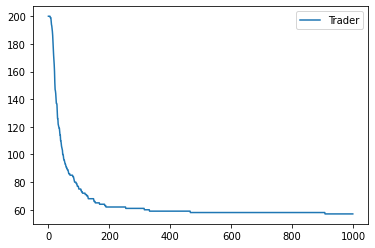

In [ ]:
# plot number of agents per time step 
results.plot(y = "Trader", use_index=True)

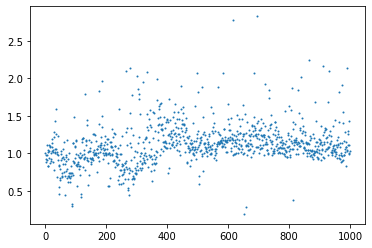

In [ ]:
# plot trade price per step 

y = list(results["Price"])
x = range(1000)

plt.scatter(x,y, s=1)

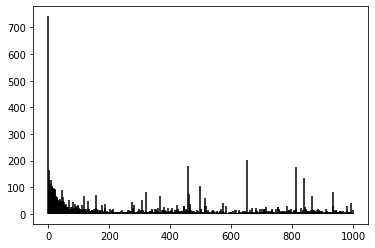

In [ ]:
# Plot trade volume improved

for i in range(1000):
  plt.vlines(i,0,results["Trade Volume"][i])

In [ ]:
#  create graph object
G = nx.Graph()

# add agent keys to make initial node set
G.add_nodes_from(list(model.schedule.agents_by_type[Trader].keys()))

# create edge list
for idx, row in agent_results.iterrows(): 
  if len(row["Trade Network"]) > 0: 
    for agent in row["Trade Network"]:
      G.add_edge(idx[1], agent)



In [ ]:
nx.node_connectivity(G), nx.average_clustering(G), nx.diameter(G), nx.global_efficiency(G)


(1, 0.41812264143982675, 6, 0.4702114723764785)

(array([58., 56., 14., 15., 15., 12., 10.,  9.,  4.,  2.]),
 array([ 1. ,  8.1, 15.2, 22.3, 29.4, 36.5, 43.6, 50.7, 57.8, 64.9, 72. ]),
 <a list of 10 Patch objects>)

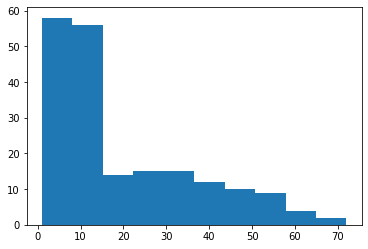

In [ ]:
degree = [d for n,d in G.degree()]
plt.hist(degree)

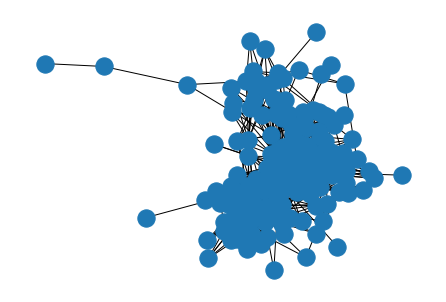

In [ ]:
nx.draw(G)